In [6]:
import numpy as np
import rospy
import rosbag

from mujoco_py import load_model_from_path, MjSim, MjSimPool, MjViewer, MjSimState
from mujoco_py.generated import const
from quatmath import euler2mat

import matplotlib.pyplot as plt

In [2]:
def get_handle_data(npy_file_name, num_files):

    data = np.load(npy_file_name + '_{}.npy'.format(0))
    for i in range(num_files):
        _data = np.load(npy_file_name + '_{}.npy'.format(i))
        data = np.vstack((data, _data))
    return data


In [8]:
handle_pose_data = get_handle_data('./data/trial3/sampled_poses',20)
handle_axis_data = get_handle_data('./data/trial3/sampled_jnts', 20)
model_prob_data = get_handle_data('./data/trial3/model_probs', 20)

In [31]:
handle_mean = []
handle_pose = []
handle_var = []
handle_pose_var = []

true_axis = np.array([1.0, 0., 0.])

for sampled_axis, sampled_poses, model_probs in zip(handle_axis_data, handle_pose_data,  model_prob_data):
    _mean = 0.0
    _mean_pose = 0.0
    _var = 0.0
    _var_pose = 0.0
    for _ax, _pose, _prob in zip(sampled_axis, sampled_poses, model_probs):
        _mean += _ax * _prob
        _mean_pose += _pose * _prob
    for _ax, _pose, _prob in zip(sampled_axis, sampled_poses, model_probs):
        _diff = _mean - _ax
        _diff_pose = _mean_pose - _pose
        _var += np.outer(_diff, _diff) * _prob
        _var_pose += np.outer(_diff_pose, _diff_pose) * _prob

    handle_mean.append(np.dot(_mean,true_axis))
    handle_var.append(np.diag(_var).sum())
    handle_pose.append(_mean_pose)
    handle_pose_var.append(_var_pose)
    
handle_mean = np.array(handle_mean)
handle_var = np.array(handle_var)

handle_mean_pose = np.array(handle_pose)
handle_var_pose = np.array(handle_pose_var)

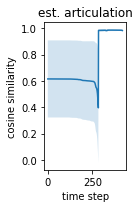

In [39]:
t = [i for i in range(len(handle_mean))]
plt.figure(figsize=(2,3))
plt.plot(t, handle_mean)
plt.fill_between(t, handle_mean - 0.5 * handle_var,
                handle_mean + 0.5 * handle_var, alpha=0.2)
plt.xlabel('time step')
plt.ylabel('cosine similarity')
plt.title('est. articulation')
plt.tight_layout()

plt.savefig('cos-sim.pdf')